In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Added on_bad_lines='skip' to handle rows with mismatched quotes or truncation errors
df = pd.read_csv("IMDB Dataset.csv", on_bad_lines='skip')

In [ ]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
df.groupby("sentiment").count()

,review
sentiment,
negative,25000
positive,25000


In [ ]:
idx = np.arange(50000)
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

X_train = df['review'][train_idx]
X_test  = df['review'][test_idx]
y_train = df['sentiment'][train_idx]
y_test  = df['sentiment'][test_idx]

clf = make_pipeline(
    CountVectorizer(),
    LogisticRegression(max_iter=2000, n_jobs=-1)
)


clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred,pos_label="positive"))
print("Recall:", recall_score(y_test, pred,pos_label="positive"))

Accuracy: 0.8876
Precision: 0.8822495606326889
Recall: 0.8966064695376067


In [ ]:
df['review_length'] = df['review'].str.len()
mean_lengths = df.groupby('sentiment')['review_length'].mean()

print(mean_lengths)

sentiment
negative    1294.06436
positive    1324.79768
Name: review_length, dtype: float64


/tmp/ipython-input-168625996.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_lengths.index, y=mean_lengths.values, palette="viridis")


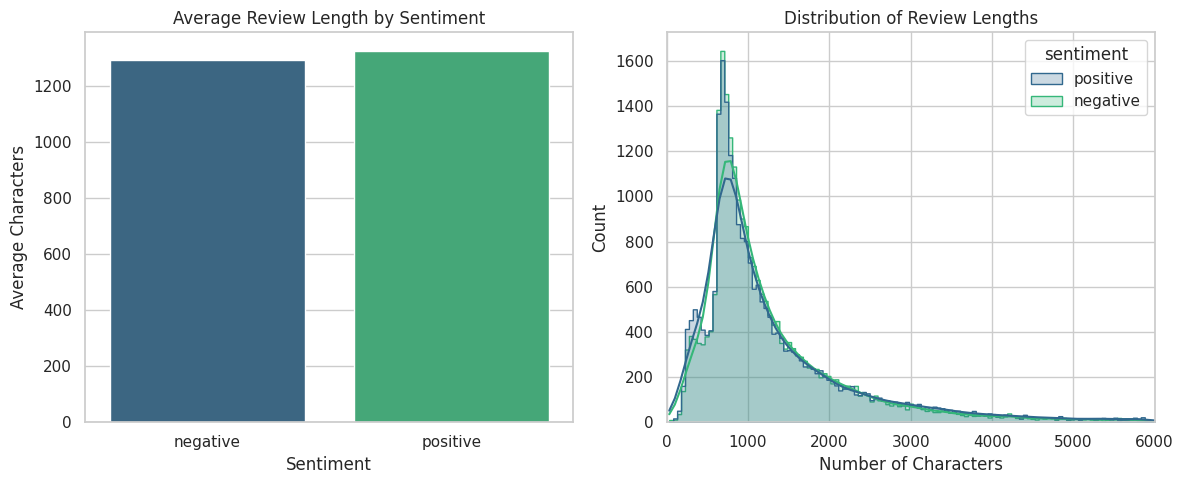

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=mean_lengths.index, y=mean_lengths.values, palette="viridis")
plt.title("Average Review Length by Sentiment")
plt.ylabel("Average Characters")
plt.xlabel("Sentiment")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x="review_length", hue="sentiment", kde=True, element="step", palette="viridis")
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Characters")
plt.xlim(0, 6000)

plt.tight_layout()
plt.show()

In [ ]:
df = df.rename(columns={"sentiment": "review_sentiment"})
vectorizer = TfidfVectorizer(
    stop_words="english",
    token_pattern=r"[a-zA-Z]{2,}",
    max_features=20000
)
tfidf_matrix = vectorizer.fit_transform(df["review"])
feature_names = vectorizer.get_feature_names_out()
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (50000, 20000)


In [ ]:
pos_idx = (df["review_sentiment"] == "positive").values
neg_idx = (df["review_sentiment"] == "negative").values

pos_mean = tfidf_matrix[pos_idx].mean(axis=0)
neg_mean = tfidf_matrix[neg_idx].mean(axis=0)

diff = np.asarray(pos_mean - neg_mean).ravel()
diff_series = pd.Series(diff, index=feature_names)

top_positive_words = diff_series.sort_values(ascending=False).head(30)
top_negative_words = diff_series.sort_values().head(30)

print("\nTop 30 Positive Words:")
print(top_positive_words)
#30 most positive words

print("\nTop 30 Negative Words:")
print(top_negative_words)
# 30 most negative words



Top 30 Positive Words:
great           0.014406
love            0.008619
best            0.008143
excellent       0.007262
wonderful       0.006149
loved           0.005117
life            0.005015
perfect         0.004664
amazing         0.004588
beautiful       0.004523
favorite        0.004053
brilliant       0.003865
family          0.003812
world           0.003707
enjoyed         0.003705
years           0.003662
war             0.003522
series          0.003519
story           0.003502
performance     0.003481
highly          0.003449
today           0.003430
fun             0.003406
superb          0.003328
young           0.003322
fantastic       0.003208
definitely      0.003128
performances    0.003061
true            0.002998
music           0.002947
dtype: float64

Top 30 Negative Words:
bad        -0.021252
movie      -0.013158
worst      -0.012846
br         -0.011799
just       -0.009229
waste      -0.008646
awful      -0.008553
terrible   -0.007995
plot       -0.00751

In [ ]:
!pip -q install transformers torch

import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)   # (B,T,1)
    summed = (last_hidden_state * mask).sum(dim=1)                   # (B,H)
    counts = mask.sum(dim=1).clamp(min=1e-9)                         # (B,1)
    return summed / counts                                           # (B,H)

@torch.no_grad()
def distilbert_embeddings_to_memmap(texts, memmap_path="distilbert_embeddings.dat",
                                   batch_size=16, max_length=256):
    """
    Converts list of texts -> memmap array of shape (n_texts, 768).
    Returns a memmap you can index like a numpy array.
    """
    n = len(texts)
    hidden_size = model.config.hidden_size  # 768

    X_mem = np.memmap(memmap_path, dtype="float32", mode="w+", shape=(n, hidden_size))

    for start in range(0, n, batch_size):
        batch_texts = texts[start:start + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        out = model(**enc)  # out.last_hidden_state: (B,T,H)
        emb = mean_pool(out.last_hidden_state, enc["attention_mask"])  # (B,H)

        X_mem[start:start + len(batch_texts)] = emb.cpu().numpy()

        if start % (batch_size * 50) == 0:
            print(f"Embedded {start}/{n} reviews...")

    X_mem.flush()
    print("Done. Saved embeddings to:", memmap_path)
    return X_mem


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
texts = df["review"].astype(str).tolist()
X_bert = distilbert_embeddings_to_memmap(
    texts,
    memmap_path="distilbert_embeddings.dat",
    batch_size=16,
    max_length=256
)

Embedded 0/50000 reviews...
Embedded 800/50000 reviews...
Embedded 1600/50000 reviews...
Embedded 2400/50000 reviews...
Embedded 3200/50000 reviews...
Embedded 4000/50000 reviews...
Embedded 4800/50000 reviews...
Embedded 5600/50000 reviews...
Embedded 6400/50000 reviews...
Embedded 7200/50000 reviews...
Embedded 8000/50000 reviews...
Embedded 8800/50000 reviews...
Embedded 9600/50000 reviews...
Embedded 10400/50000 reviews...
Embedded 11200/50000 reviews...
Embedded 12000/50000 reviews...
Embedded 12800/50000 reviews...
Embedded 13600/50000 reviews...
Embedded 14400/50000 reviews...
Embedded 15200/50000 reviews...
Embedded 16000/50000 reviews...
Embedded 16800/50000 reviews...
Embedded 17600/50000 reviews...
Embedded 18400/50000 reviews...
Embedded 19200/50000 reviews...
Embedded 20000/50000 reviews...
Embedded 20800/50000 reviews...
Embedded 21600/50000 reviews...
Embedded 22400/50000 reviews...
Embedded 23200/50000 reviews...
Embedded 24000/50000 reviews...
Embedded 24800/50000 revi

In [ ]:
y = (df["review_sentiment"] == "positive").astype(int).values

idx = np.arange(len(df))

train_idx, test_idx = train_test_split(
    idx, test_size=10000, random_state=552, stratify=y
)

y_train = y[train_idx]
y_test  = y[test_idx]


In [ ]:
X_tfidf_train = tfidf_matrix[train_idx]
X_tfidf_test  = tfidf_matrix[test_idx]

tfidf_models = {
    "TFIDF_LogReg": LogisticRegression(max_iter=5000, n_jobs=-1),
    "TFIDF_LinearSVM": LinearSVC(),
    "TFIDF_MultinomialNB": MultinomialNB(),
    "TFIDF_SGD_LogLoss": SGDClassifier(loss="log_loss", random_state=42),
}


In [ ]:
X_bert_train = X_bert[train_idx]
X_bert_test  = X_bert[test_idx]

bert_models = {
    "BERT_LogReg": LogisticRegression(max_iter=5000, n_jobs=-1),
    "BERT_LinearSVM": LinearSVC(),
    "BERT_GaussianNB": GaussianNB(),
    "BERT_SGD_LogLoss": SGDClassifier(loss="log_loss", random_state=42),
}


In [ ]:
def eval_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, pos_label=1)
    rec = recall_score(y_test, pred, pos_label=1)


    auc = None
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, scores)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        auc = roc_auc_score(y_test, scores)

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "auc": auc
    }


In [ ]:
results = []

# TF-IDF
for name, model in tfidf_models.items():
    results.append(eval_model(name, model, X_tfidf_train, X_tfidf_test, y_train, y_test))

# BERT
for name, model in bert_models.items():
    results.append(eval_model(name, model, X_bert_train, X_bert_test, y_train, y_test))

import pandas as pd
results_df = pd.DataFrame(results).sort_values("accuracy", ascending=False)
results_df


,model,accuracy,precision,recall,auc
0,TFIDF_LogReg,0.8938,0.881294,0.9102,0.960655
1,TFIDF_LinearSVM,0.8899,0.880094,0.9028,0.957939
3,TFIDF_SGD_LogLoss,0.8843,0.866349,0.9088,0.953393
5,BERT_LinearSVM,0.8689,0.872250,0.8644,0.944599
4,BERT_LogReg,0.8672,0.870909,0.8622,0.943477
2,TFIDF_MultinomialNB,0.8637,0.867448,0.8586,0.938572
7,BERT_SGD_LogLoss,0.8626,0.843241,0.8908,0.940497
6,BERT_GaussianNB,0.7761,0.792913,0.7474,0.851948


In [ ]:
#TF IDF models had better results than BERT models!